In [7]:
import sys
import os

package_path: str = '../..'
if package_path not in sys.path:
    sys.path.append(package_path)

In [8]:
%reload_ext autoreload
%autoreload 2

In [19]:
from src.analyzer.converter import load_npz
from src.filesystem import get_run_scan_directory
from src.config.config import load_config, ExpConfig


config: ExpConfig = load_config(reload=True)
config.path

ExpPaths(log_dir='./logs', load_dir='E:\\XFEL\\sample_data', analysis_dir='E:\\XFEL\\sample_data', mat_dir='E:\\XFEL\\sample_data\\mat_files', processed_dir='E:\\XFEL\\sample_data\\processed_data', output_dir='E:\\XFEL\\sample_data\\output_data')

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.typing as npt
from roi_rectangle import RoiRectangle

In [28]:
run_n: int = 144
npz_dir: str = get_run_scan_directory(config.path.processed_dir, run_n, 1)
npz_file: str = os.path.join(npz_dir, f"run={run_n:0>4}_scan=0001.npz")

_data: dict[str: npt.NDArray] = load_npz(npz_file)
delays: npt.NDArray = _data["delay"]
images: npt.NDArray = _data["pon"]

print(f'Load "{npz_file}"')
print(f'{delays.shape = }')
print(f'{images.shape = }')

Load "E:\XFEL\sample_data\processed_data\run=144\scan=001\run=0144_scan=0001.npz"
delays.shape = (137,)
images.shape = (137, 514, 1030)


In [24]:
images = np.maximum(0, images)

Text(0.5, 1.0, 'Images Sum')

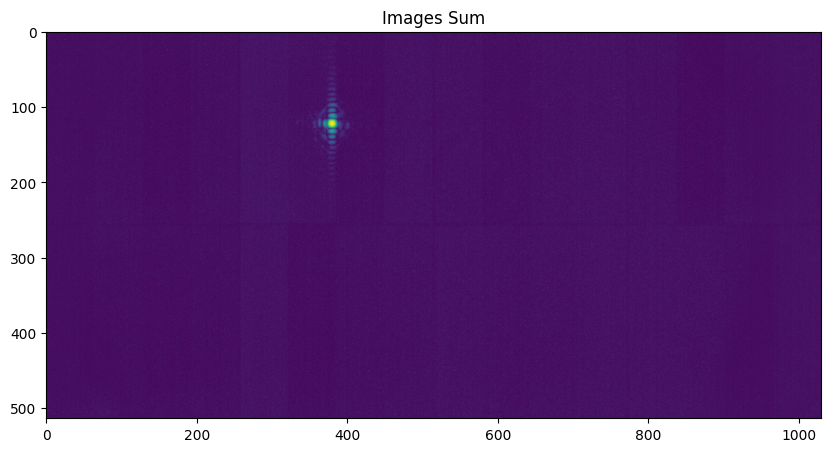

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.imshow(np.log1p(images.sum(0)))
ax.set_title("Images Sum")

RoiRectangle(x1=352, y1=98, x2=411, y2=159)

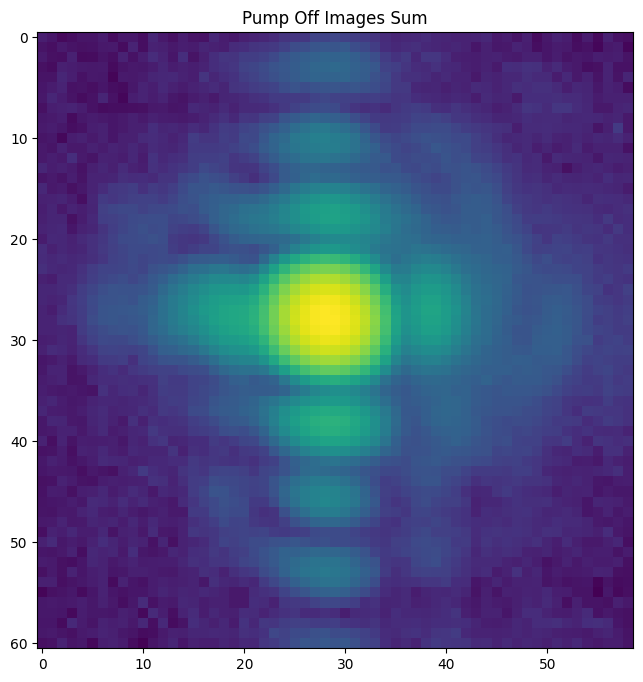

In [29]:
roi_rect: RoiRectangle = RoiRectangle(x1=352, y1=98, x2=411, y2=159)
roi_images: npt.NDArray = roi_rect.slice(images)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.imshow(np.log1p(roi_images.sum(0)))
ax.set_title("Pump Off Images Sum")

roi_rect

RoiRectangle(x1=373, y1=118, x2=388, y2=134)

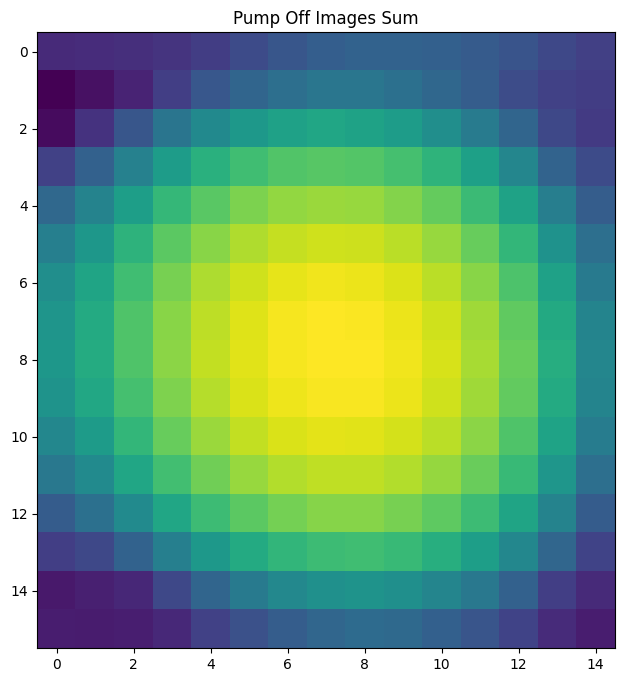

In [31]:
roi_rect: RoiRectangle = RoiRectangle(x1=373, y1=118, x2=388, y2=134)
roi_images: npt.NDArray = roi_rect.slice(images)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.imshow(np.log1p(roi_images.sum(0)))
ax.set_title("Pump Off Images Sum")

roi_rect

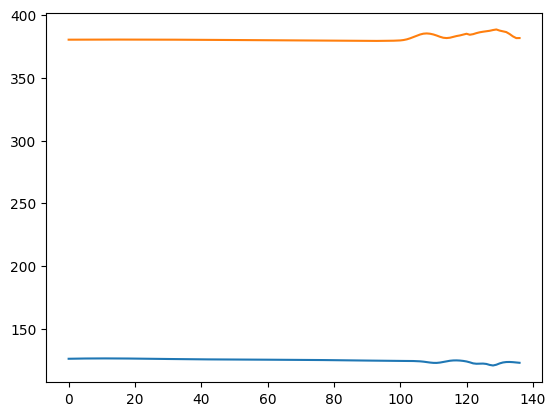

In [35]:
import numpy as np
from scipy.ndimage import center_of_mass, gaussian_filter
from scipy.interpolate import UnivariateSpline

def dynamic_roi_tracking(frames, initial_roi: RoiRectangle, smoothing_factor=2):
    centers = []
    roi = initial_roi

    for frame in frames:
        # Apply Gaussian filter to smooth noise
        smoothed_frame = gaussian_filter(frame, sigma=2)

        # Crop ROI dynamically
        roi_frame = roi.slice(smoothed_frame)

        # Calculate center of mass within ROI
        com = center_of_mass(roi_frame)
        global_com = (roi.y1 + com[0], roi.x1 + com[1])
        centers.append(global_com)

        # Update ROI dynamically
        roi = RoiRectangle(
            y1=max(0, int(global_com[0] - 10)),  # Adjust ROI size
            y2=min(frame.shape[0], int(global_com[0] + 10)),
            x1=max(0, int(global_com[1] - 10)),
            x2=min(frame.shape[1], int(global_com[1] + 10)),
        )

    # Smooth the trajectory
    centers = np.array(centers)
    smoothed_x = UnivariateSpline(range(len(centers)), centers[:, 0], s=smoothing_factor)
    smoothed_y = UnivariateSpline(range(len(centers)), centers[:, 1], s=smoothing_factor)

    return smoothed_x(range(len(centers))), smoothed_y(range(len(centers)))


xs, ys = dynamic_roi_tracking(images, roi_rect)
plt.plot(xs)
plt.plot(ys)

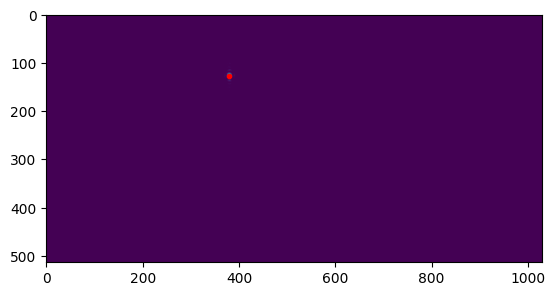

interactive(children=(IntSlider(value=0, description='Time:', max=136), Output()), _dom_classes=('widget-inter…

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

# 데이터 생성 (가상의 이미지 시퀀스와 무게중심 데이터)
num_frames = images.shape[0]
image_size = images.shape[1:]

# 이미지 데이터 (2D Gaussians의 이동 시뮬레이션)
frames = images

# 무게중심 데이터
centers = np.stack([xs, ys]).T

# 초기 설정
initial_frame = 0

# Matplotlib Figure 생성
fig, ax = plt.subplots()

# 초기 이미지와 무게중심 표시
image_plot = ax.imshow(frames[initial_frame], cmap='viridis', interpolation='nearest')
center_plot, = ax.plot(centers[initial_frame][1], centers[initial_frame][0], 'r.')  # 무게중심 표시

# 슬라이더 업데이트 함수
def update(frame_idx):
    image_plot.set_data(frames[frame_idx])  # 새로운 프레임 데이터 설정
    center_plot.set_data(centers[frame_idx][1], centers[frame_idx][0])  # 무게중심 업데이트
    ax.set_title(f"Frame: {frame_idx}, Center: {centers[frame_idx]}")
    fig.canvas.draw_idle()

# ipywidgets 슬라이더 생성
slider = IntSlider(min=0, max=num_frames - 1, step=1, value=initial_frame, description='Time:')

# interact를 사용하여 슬라이더와 업데이트 함수 연결
interact(update, frame_idx=slider)

plt.show()

In [47]:
from sklearn.cluster import DBSCAN

def dbscan_peak_tracking(frames, eps=5, min_samples=10):
    trajectories = []

    for frame in frames:
        # Threshold to extract peaks
        thresholded = (frame > frame.mean()).astype(np.uint8)
        coordinates = np.column_stack(np.nonzero(thresholded))

        # Apply DBSCAN clustering
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(coordinates)
        cluster_centers = np.array([coordinates[clustering.labels_ == label].mean(axis=0) 
                                    for label in set(clustering.labels_) if label != -1])

        trajectories.append(cluster_centers)

    return trajectories

from scipy.signal import cwt, ricker
import numpy as np

def wavelet_peak_tracking(frames, widths=np.arange(1, 10)):
    trajectories = []

    for frame in frames:
        # Apply Wavelet Transform
        transformed = cwt(frame.sum(axis=0), ricker, widths)
        peak_positions = np.argmax(transformed, axis=1)
        trajectories.append(peak_positions)

    # Smooth trajectories
    trajectories = np.array(trajectories)
    smoothed_trajectories = [np.convolve(trajectory, np.ones(5)/5, mode='same') for trajectory in trajectories.T]

    return np.array(smoothed_trajectories).T



C:\Users\ISAAC\AppData\Local\Temp\ipykernel_18384\4045423178.py:28: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  transformed = cwt(frame.sum(axis=0), ricker, widths)


AttributeError: 'list' object has no attribute 'T'

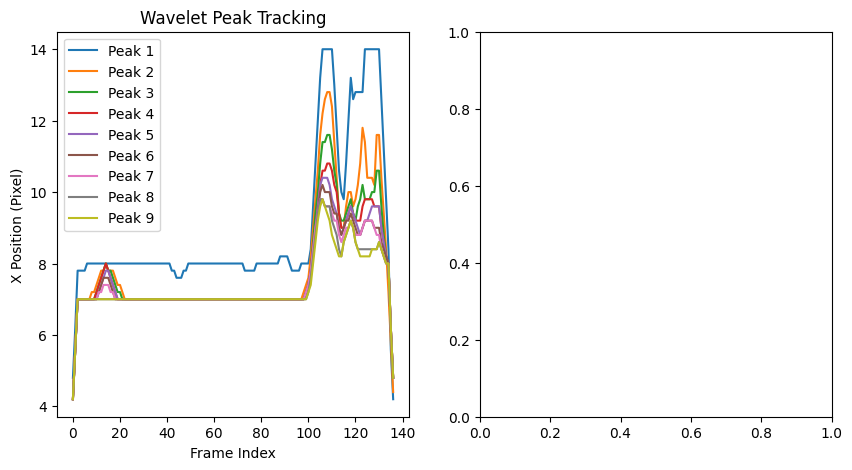

In [ ]:
import matplotlib.pyplot as plt

# 예제 데이터 생성 (랜덤 프레임)
frames = roi_images.copy()

# 1. Wavelet 기반 추적 결과
wavelet_trajectories = wavelet_peak_tracking(frames)

# 2. DBSCAN 기반 추적 결과
dbscan_trajectories = dbscan_peak_tracking(frames)

# 3. Wavelet 결과 플롯
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
for i, trajectory in enumerate(wavelet_trajectories.T):  # 각 peak에 대해 x, y 추적
    plt.plot(range(len(trajectory)), trajectory, label=f"Peak {i + 1}")
plt.title("Wavelet Peak Tracking")
plt.xlabel("Frame Index")
plt.ylabel("X Position (Pixel)")
plt.legend()

# 4. DBSCAN 결과 플롯
plt.subplot(1, 2, 2)
for i, frame_centers in enumerate(dbscan_trajectories):  # 각 프레임의 클러스터 중심
    for j, (y, x) in enumerate(frame_centers):  # 클러스터별 x, y 위치
        plt.scatter(i, x, label=f"Cluster {j + 1}" if i == 0 else "", alpha=0.7)
        
plt.title("DBSCAN Peak Tracking")
plt.xlabel("Frame Index")
plt.ylabel("X Position (Pixel)")
plt.legend()

plt.tight_layout()
plt.show()
